In [1]:
import importlib
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
from multi_loc import covariance, assimilate

In [3]:
%matplotlib inline

In [4]:
def imshow(X, title=None, vmin=None, vmax=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title(title)

In [5]:
dimension = 100
rho0 = 20
ens_size = int(20)
obs_size = int(1e3)
rho = np.arange(dimension, dtype=float)
rho = np.minimum(rho, (dimension - rho) % dimension)

In [6]:
H = np.eye(dimension)[::2]
y_size = H.shape[0]

In [7]:
importlib.reload(assimilate)

<module 'multi_loc.assimilate' from '/Users/harty/Documents/multi_loc/multi_loc/assimilate.py'>

In [8]:
eig_val, eig_vec, P = covariance.generate_circulant(
    rho, rho0, covariance.correlation_exp,
    return_Corr = True)
P = P.real

R = np.eye(y_size)

returned = assimilate.transformation_matrices(
    H, eig_val_p=eig_val, eig_vec_p=eig_vec,
    R=R, return_Ts=True)

P_sqrt, P_inv_sqrt = returned[:2]
R_sqrt, R_inv_sqrt = returned[2:4]
U, S, VT = returned[4:7]
Tx, Tx_inv, Ty, Ty_inv = returned[7:]

Log10(condition):  3.204300912305241


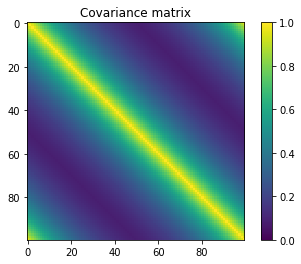

In [9]:
imshow(P, title='Covariance matrix', vmin=0, vmax=1)
print('Log10(condition): ',
      np.log10(np.linalg.cond(P)))

In [10]:
mu = np.zeros(dimension)
X_ens = assimilate.generate_ensemble(
    ens_size, mu, P_sqrt)
ground_truth = assimilate.generate_ensemble(
    1, mu, P_sqrt)
Y_ens = H @ ground_truth + R_sqrt @ np.random.randn(y_size, obs_size)

In [11]:
X_ens_p = Tx @ X_ens
Y_ens_p = Ty @ Y_ens

In [12]:
def plots_t(S, Tx, Tx_inv, Ty_inv, truth, X_ens,
            rmse, rmse_t, y=None, ii=-1):
    plt.figure()
    plt.plot(S @ Tx @ ground_truth, '--')
    plt.plot(S @ X_ens.mean(axis=1), '-')
    if y is not None:
        plt.scatter(np.arange(y_size), y, marker='.')
    plt.legend(['S @ x\'', 'S @ x\' ens mean', 'y\''])
    plt.title(
        f'In transformed space: {ii + 1}'
        + f'; rmse: {rmse_t:0.5}')


    plt.figure()
    plt.plot(ground_truth, '--')
    plt.plot(Tx_inv @ X_ens.mean(axis=1), '-')
    if y is not None:
        plt.scatter(np.arange(dimension)[::2],
                    Ty_inv @ y, marker='.')
    plt.legend(['x', 'x ens mean', 'y'])
    plt.title(f'In real space: {ii + 1}'
              + f'; rmse: {rmse:0.5}')

# transformed KF

It took:  0.007050999005635579


/Users/harty/anaconda3/envs/multiloc/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Text(0,0.5,'RMSE')

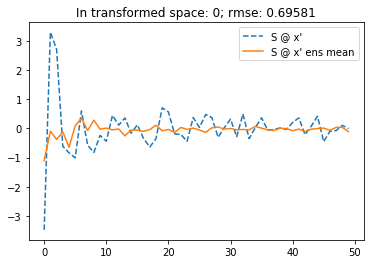

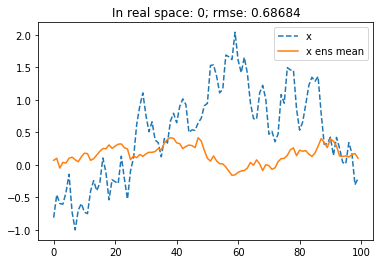

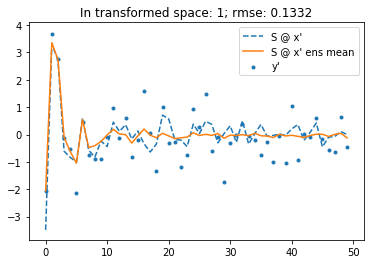

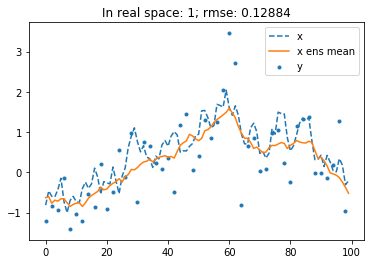

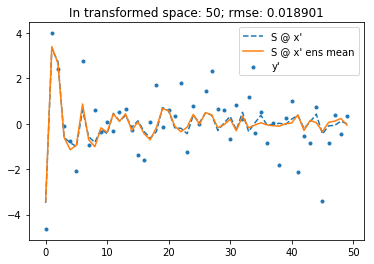

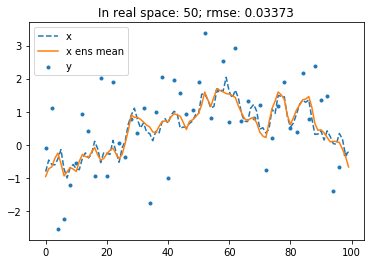

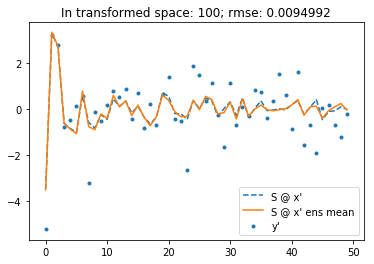

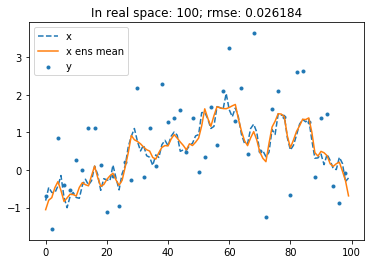

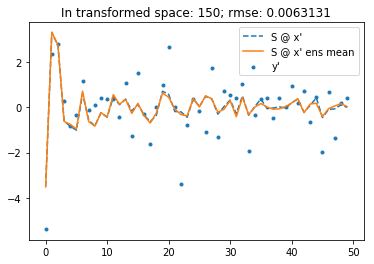

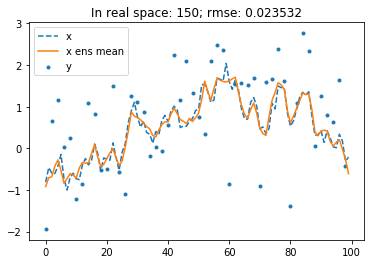

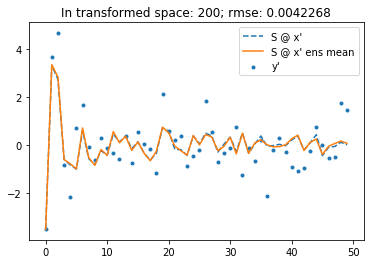

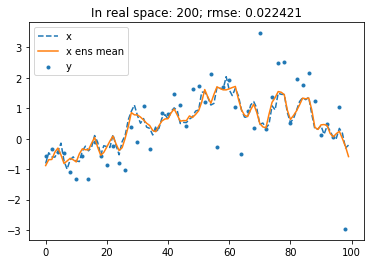

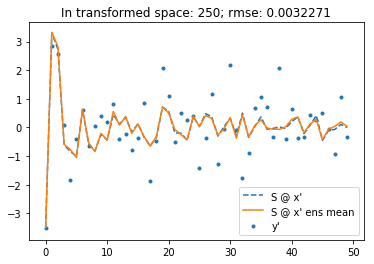

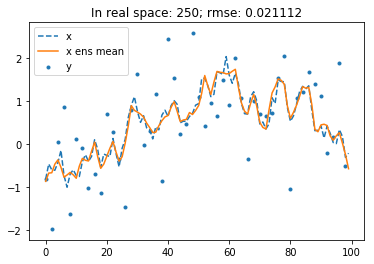

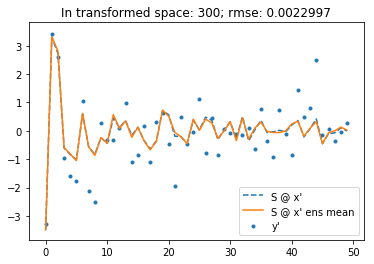

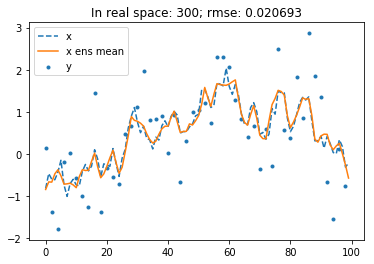

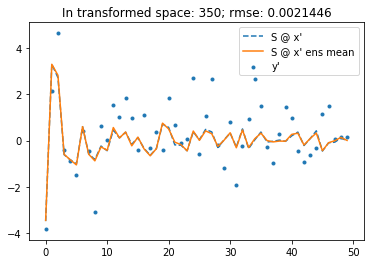

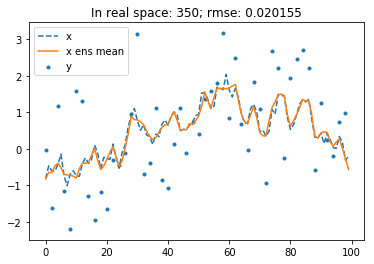

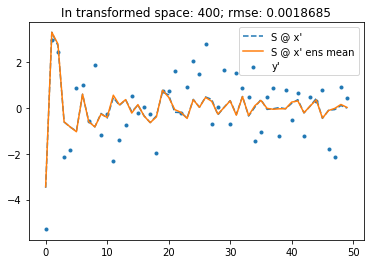

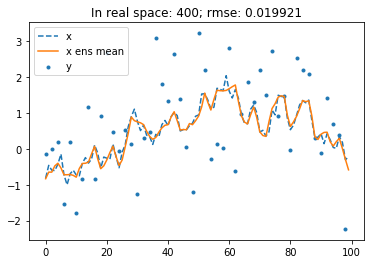

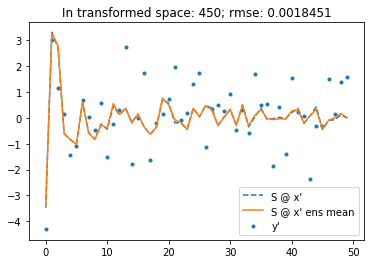

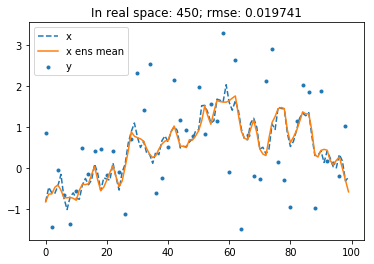

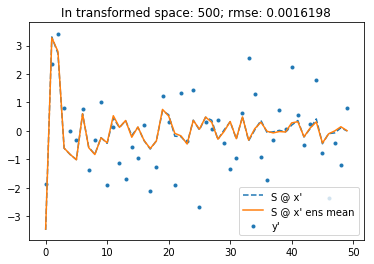

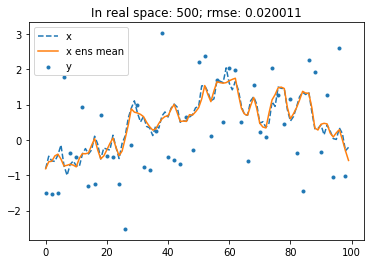

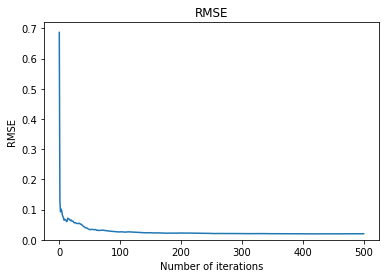

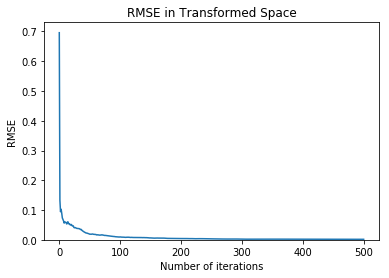

In [13]:
X_ens_kf = X_ens_p.copy()
S_kf_reduced = S.diagonal()[:, None]
P_kf_reduced = np.ones(y_size)[:, None]
I_reduced = np.ones(y_size)[:, None]

iterations = 500
rmse = np.ones(iterations + 1)*np.nan
rmse_t = rmse.copy()
error = (ground_truth
         - Tx_inv @ X_ens_kf.mean(axis=1)[:, None])
error_t = (S @ Tx @ ground_truth
           - S @ X_ens_kf.mean(axis=1)[:, None])
rmse[0] = (error**2).mean()
rmse_t[0] = (error_t**2).mean()

plots_t(S, Tx, Tx_inv, Ty_inv,
        ground_truth, X_ens_kf, rmse[0], rmse_t[0])

time0 = time.time()
for ii in range(iterations):
    Y_obs = (Y_ens_p[:, ii][:, None] 
             + np.random.randn(y_size, ens_size))
    K = ((S_kf_reduced * P_kf_reduced)
        / (1 + S_kf_reduced**2 * P_kf_reduced))
    X_ens_kf[:y_size] = (X_ens_kf[:y_size]
                         + K * (Y_obs - S @ X_ens_kf))
    error = (ground_truth
             - Tx_inv @ X_ens_kf.mean(axis=1)[:, None])
    error_t = (S @ Tx @ ground_truth
               - S @ X_ens_kf.mean(axis=1)[:, None])
    rmse[ii + 1] = (error**2).mean()
    rmse_t[ii + 1] = (error_t**2).mean()
    if (ii + 1) % round(iterations/10) == 0 or ii + 1 == 1 :
        plots_t(S, Tx, Tx_inv, Ty_inv, 
                ground_truth, X_ens_kf, rmse[ii + 1],
                rmse_t[ii + 1], y=Y_ens_p[:, ii], ii=ii)
    P_kf_reduced = (I_reduced
                    - K * S_kf_reduced)*P_kf_reduced
time1 = time.time()
elapsed = (time1 - time0)/60
print('It took: ', elapsed)
plt.figure()
plt.plot(rmse)
plt.ylim([0, None])
plt.title('RMSE')
plt.xlabel('Number of iterations')
plt.ylabel('RMSE')

plt.figure()
plt.plot(rmse_t)
plt.ylim([0, None])
plt.title('RMSE in Transformed Space')
plt.xlabel('Number of iterations')
plt.ylabel('RMSE')

In [14]:
def plots(truth, X_ens, rmse,
          y=None, ii=-1):
    
    plt.figure()
    plt.plot(ground_truth, '--')
    plt.plot(X_ens.mean(axis=1), '-')
    if y is not None:
        plt.scatter(np.arange(dimension)[::2], y, marker='.')
    plt.legend(['x', 'x ens mean', 'y'])
    plt.title(f'In real space: {ii + 1}; rmse: {rmse:0.5}')

# Standard KF

It took:  0.007744034131368001


Text(0,0.5,'RMSE')

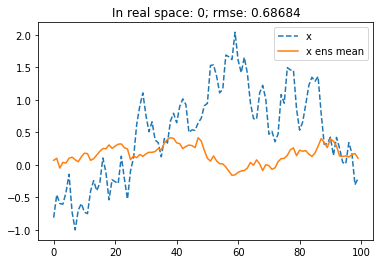

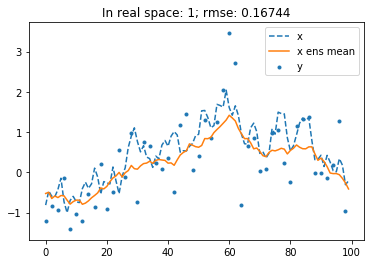

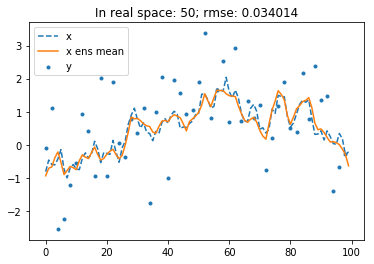

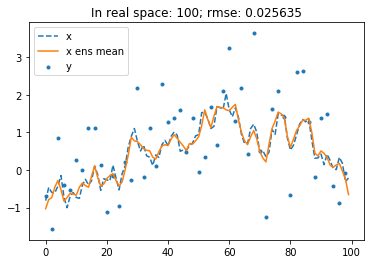

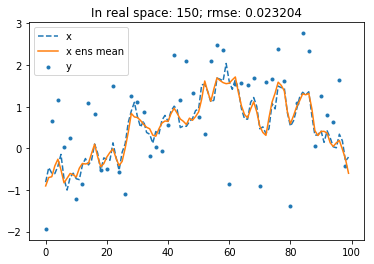

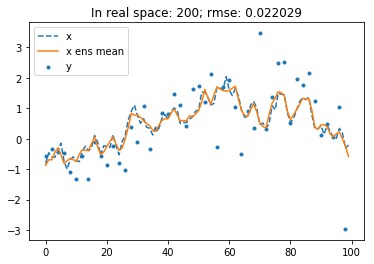

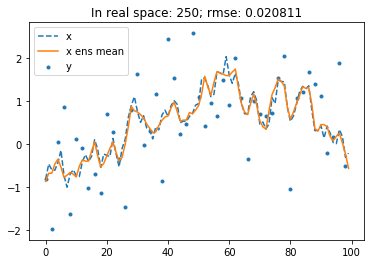

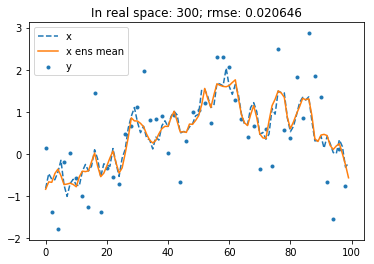

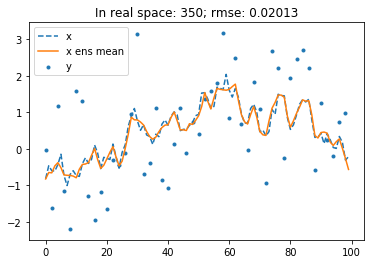

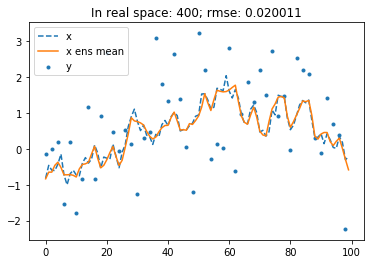

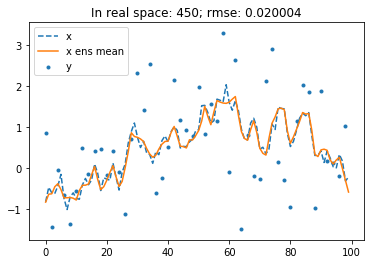

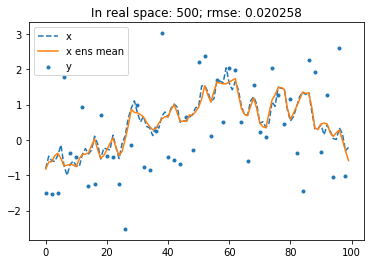

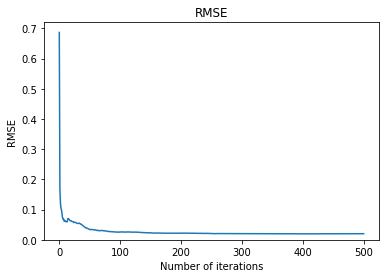

In [15]:
X_ens_kf = X_ens.copy()
P_kf = P.copy()

iterations = 500
rmse = np.ones(iterations + 1)*np.nan
error = (ground_truth
         - X_ens_kf.mean(axis=1)[:, None])
rmse[0] = (error**2).mean()

plots(ground_truth, X_ens_kf, rmse[0])
time0 = time.time()
for ii in range(iterations):
    mu = X_ens_kf.mean(axis=1)[:, None]
    Y_obs = (Y_ens[:, ii][:, None] 
             + R_sqrt @ np.random.randn(y_size, ens_size))
    K = (P_kf @ H.T
         @ sp.linalg.inv(
             R + H @ P_kf @ H.T))
    X_ens_kf = X_ens_kf + K @ (Y_obs - H @ X_ens_kf)
    error = (ground_truth
             - X_ens_kf.mean(axis=1)[:, None])
    rmse[ii + 1] = (error**2).mean()
    if (ii + 1) % round(iterations/10) == 0 or ii + 1 == 1 :
        plots(ground_truth, X_ens_kf, rmse[ii + 1],
              y=Y_ens[:, ii], ii=ii)
    P_kf = (np.eye(dimension) - K @ H) @ P_kf
time1 = time.time()
elapsed = (time1 - time0)/60
print('It took: ', elapsed)

plt.figure()
plt.plot(rmse)
plt.ylim([0, None])
plt.title('RMSE')
plt.xlabel('Number of iterations')
plt.ylabel('RMSE')

# transformed EnKF

It took:  0.00953831672668457


/Users/harty/anaconda3/envs/multiloc/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Text(0,0.5,'RMSE')

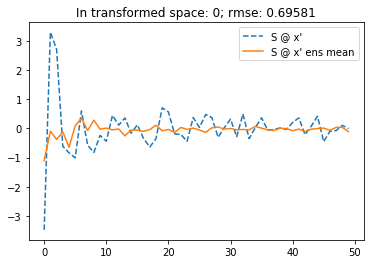

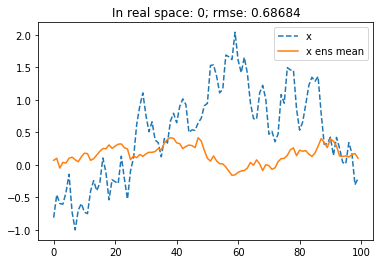

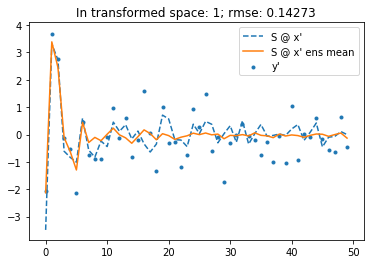

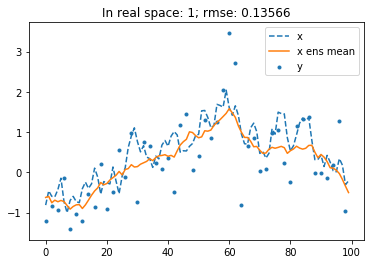

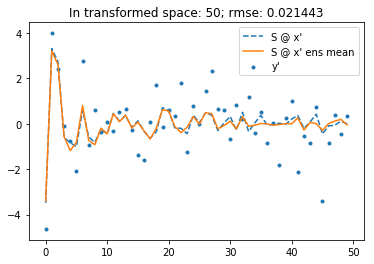

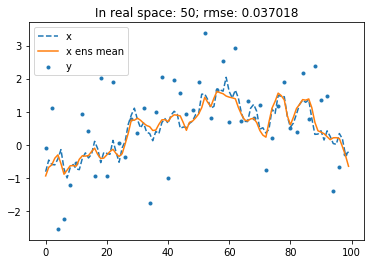

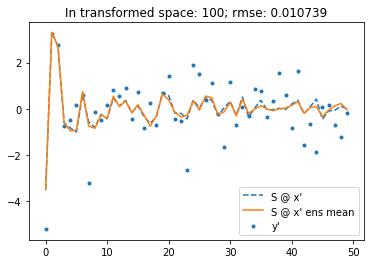

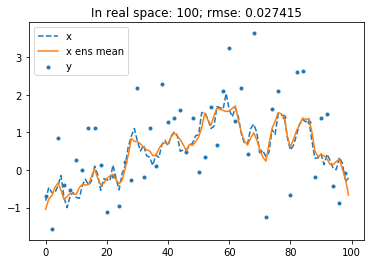

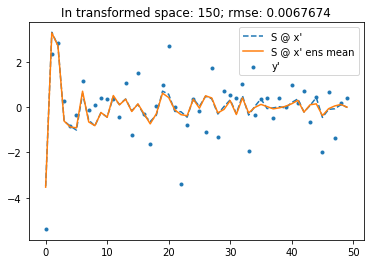

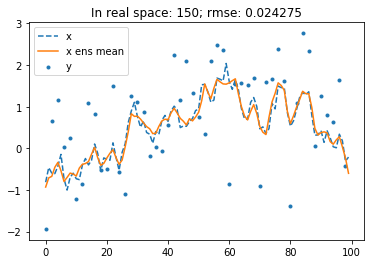

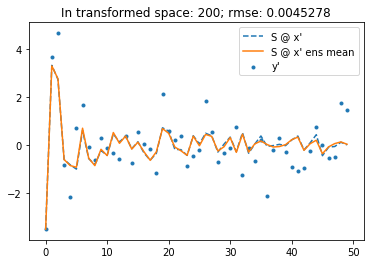

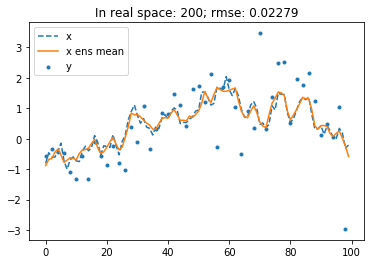

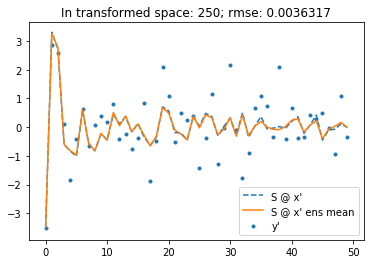

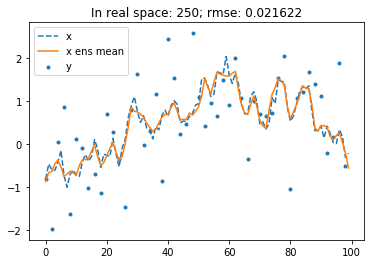

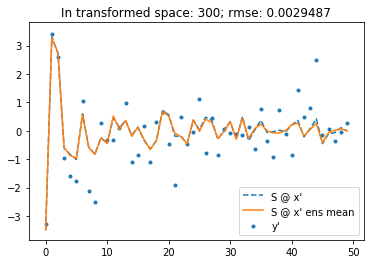

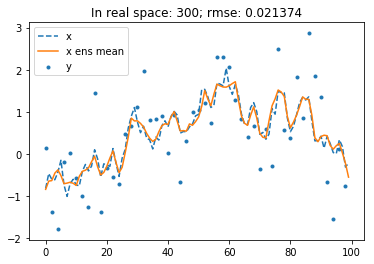

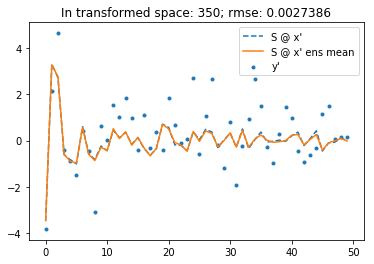

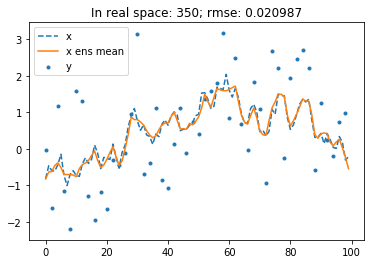

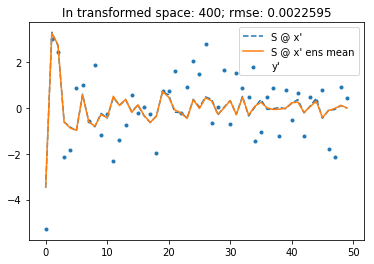

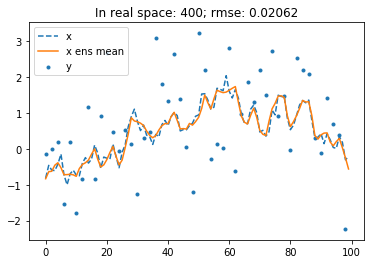

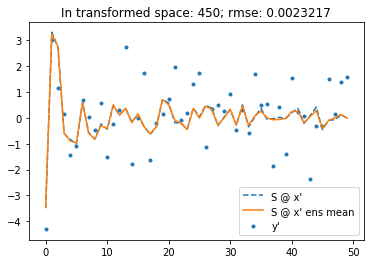

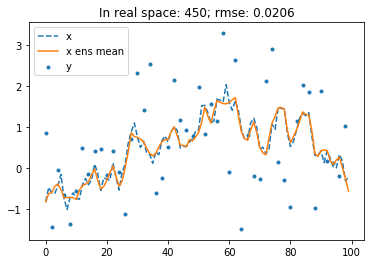

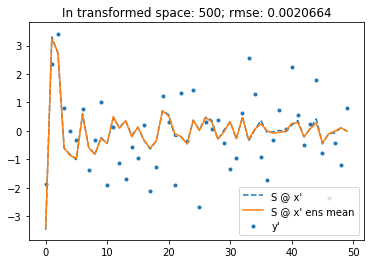

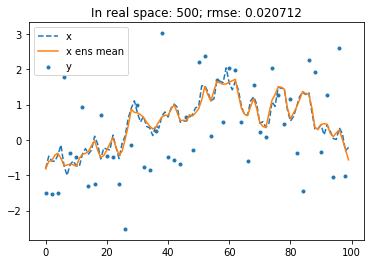

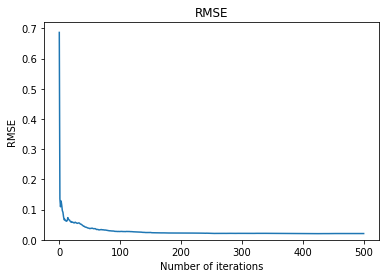

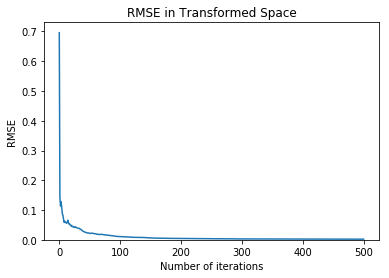

In [16]:
X_ens_kf = X_ens_p.copy()
S_kf_reduced = S.diagonal()[:, None]
P_kf_reduced = np.ones(y_size)[:, None]
I_reduced = np.ones(y_size)[:, None]

iterations = 500
rmse = np.ones(iterations + 1)*np.nan
rmse_t = rmse.copy()
error = (ground_truth
         - Tx_inv @ X_ens_kf.mean(axis=1)[:, None])
error_t = (S @ Tx @ ground_truth
           - S @ X_ens_kf.mean(axis=1)[:, None])
rmse[0] = (error**2).mean()
rmse_t[0] = (error_t**2).mean()

plots_t(S, Tx, Tx_inv, Ty_inv,
      ground_truth, X_ens_kf, rmse[0], rmse_t[0])

time0 = time.time()
for ii in range(iterations):
    # mu_p = X_ens_kf.mean(axis=1)[:, None]
    Y_obs = (Y_ens_p[:, ii][:, None] 
             + U.T @ np.random.randn(y_size, ens_size))
    P_kf_reduced = np.var(X_ens_kf[:y_size], axis=1)[:, None]
    K = ((S_kf_reduced * P_kf_reduced)
        / (1 + S_kf_reduced**2 * P_kf_reduced))
    X_ens_kf[:y_size] = (X_ens_kf[:y_size]
                         + K * (Y_obs - S @ X_ens_kf))
    error = (ground_truth
             - Tx_inv @ X_ens_kf.mean(axis=1)[:, None])
    error_t = (S @ Tx @ ground_truth
               - S @ X_ens_kf.mean(axis=1)[:, None])
    rmse[ii + 1] = (error**2).mean()
    rmse_t[ii + 1] = (error_t**2).mean()
    if (ii + 1) % round(iterations/10) == 0 or ii + 1 == 1 :
        plots_t(S, Tx, Tx_inv, Ty_inv,
              ground_truth, X_ens_kf, rmse[ii + 1],
              rmse_t[ii + 1], y=Y_ens_p[:, ii], ii=ii)
time1 = time.time()
elapsed = (time1 - time0)/60
print('It took: ', elapsed)
plt.figure()
plt.plot(rmse)
plt.ylim([0, None])
plt.title('RMSE')
plt.xlabel('Number of iterations')
plt.ylabel('RMSE')

plt.figure()
plt.plot(rmse_t)
plt.ylim([0, None])
plt.title('RMSE in Transformed Space')
plt.xlabel('Number of iterations')
plt.ylabel('RMSE')

# Standard EnKF (No loc)

It took:  0.008086884021759033 

Number of ensemble members:  20 



Text(0,0.5,'RMSE')

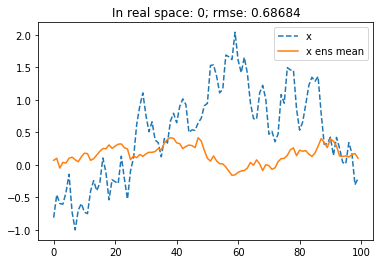

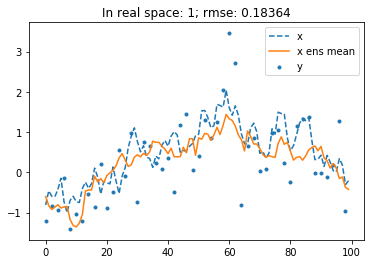

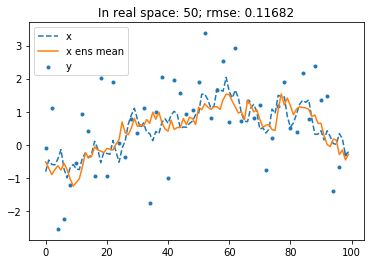

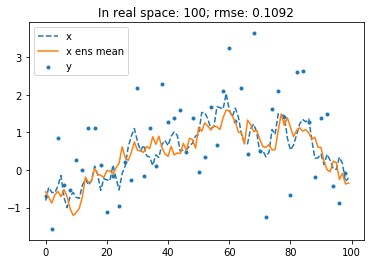

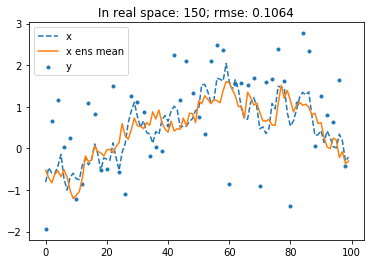

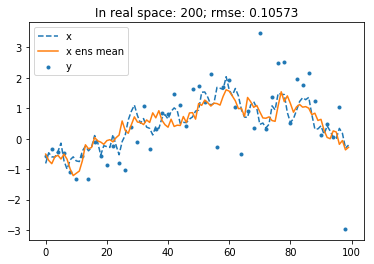

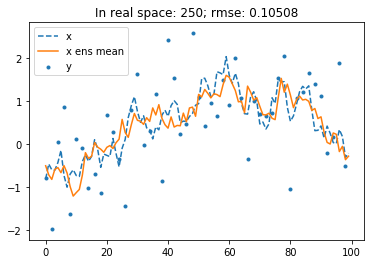

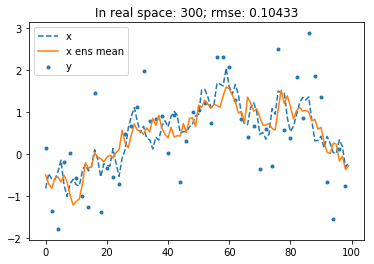

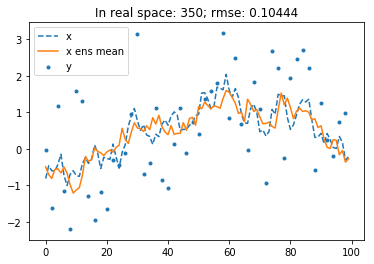

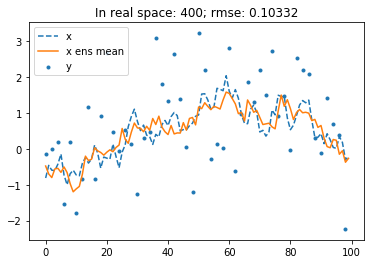

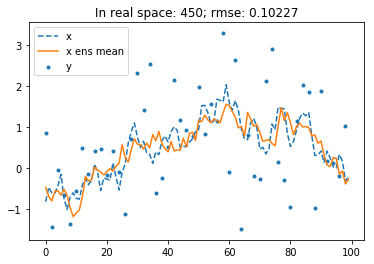

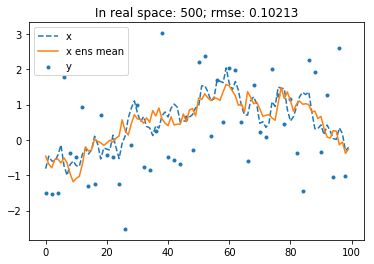

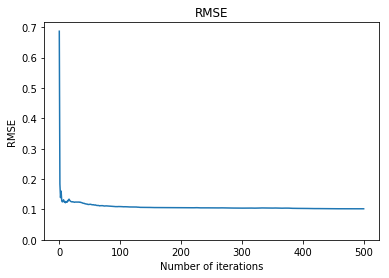

In [17]:
X_ens_kf = X_ens.copy()
P_kf = P.copy()

iterations = 500
rmse = np.ones(iterations + 1)*np.nan
error = (ground_truth
         - X_ens_kf.mean(axis=1)[:, None])
rmse[0] = (error**2).mean()

plots(ground_truth, X_ens_kf, rmse[0])
time0 = time.time()
for ii in range(iterations):
    mu = X_ens_kf.mean(axis=1)[:, None]
    Y_obs = (Y_ens[:, ii][:, None] 
             + R_sqrt @ np.random.randn(y_size, ens_size))
    P_kf = np.cov(X_ens_kf)
    K = (P_kf @ H.T
         @ sp.linalg.inv(
             R + H @ P_kf @ H.T))
    X_ens_kf = X_ens_kf + K @ (Y_obs - H @ X_ens_kf)
    error = (ground_truth
             - X_ens_kf.mean(axis=1)[:, None])
    rmse[ii + 1] = (error**2).mean()
    if (ii + 1) % round(iterations/10) == 0 or ii + 1 == 1 :
        plots(ground_truth, X_ens_kf, rmse[ii + 1],
              y=Y_ens[:, ii], ii=ii)
time1 = time.time()
elapsed = (time1 - time0)/60
print('It took: ', elapsed, '\n')
print('Number of ensemble members: ', ens_size, '\n')

plt.figure()
plt.plot(rmse)
plt.ylim([0, None])
plt.title('RMSE')
plt.xlabel('Number of iterations')
plt.ylabel('RMSE')

# With P approximation

In [18]:
eig_num = 20
P_ens = (eig_vec[:, :eig_num]  @ np.diag(eig_val[:eig_num])
         @ eig_vec[:, :eig_num].conj().T).real
returned = assimilate.transformation_matrices(
    H, P=P_ens, R=R, return_Ts=True)

P_sqrt_ens, P_inv_sqrt_ens = returned[:2]
R_sqrt, R_inv_sqrt = returned[2:4]
U_ens, S_ens, VT_ens = returned[4:7]
Tx_ens, Tx_inv_ens, Ty_ens, Ty_inv_ens = returned[7:]

X_ens_p2 = Tx_ens @ X_ens
Y_ens_p2 = Ty_ens @ Y_ens

It took:  0.008296803633371989 

Number of eigenvalues:  20 

Number of ensemble members:  20 



/Users/harty/anaconda3/envs/multiloc/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Text(0,0.5,'RMSE')

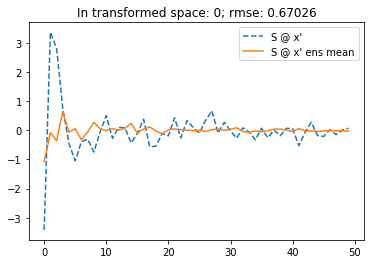

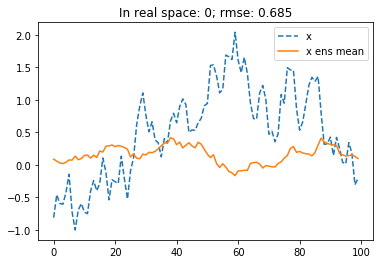

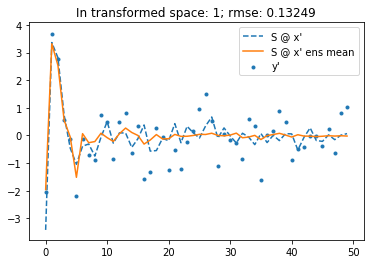

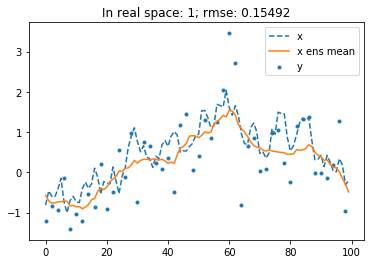

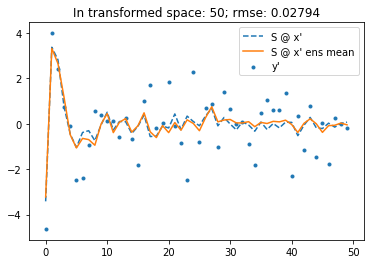

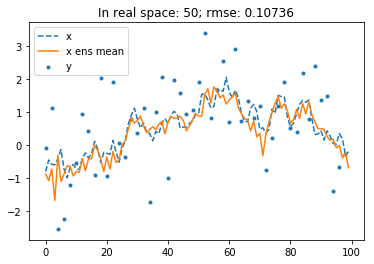

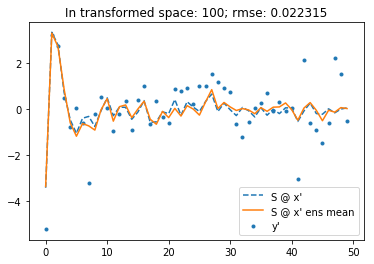

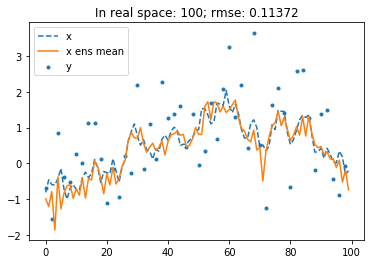

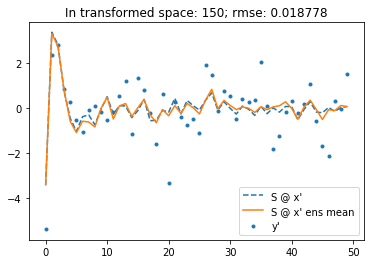

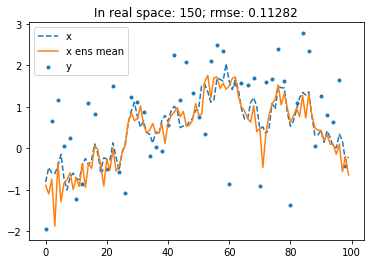

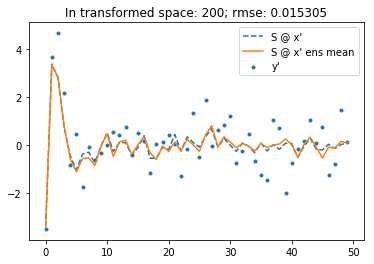

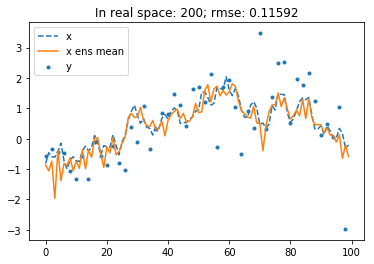

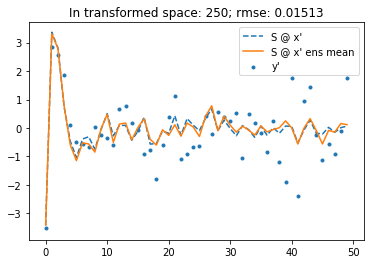

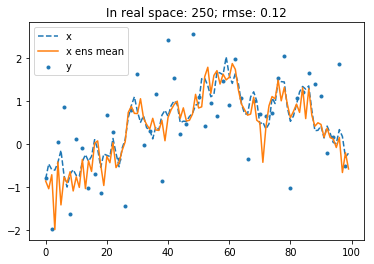

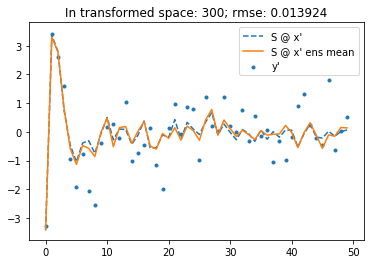

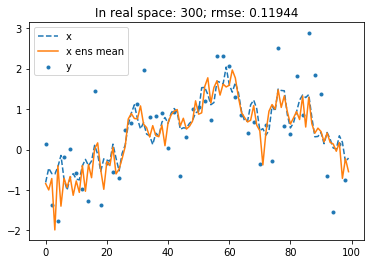

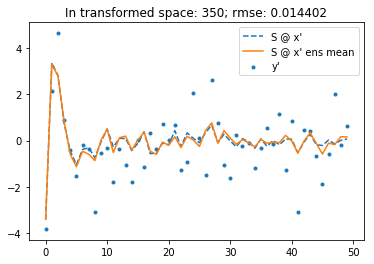

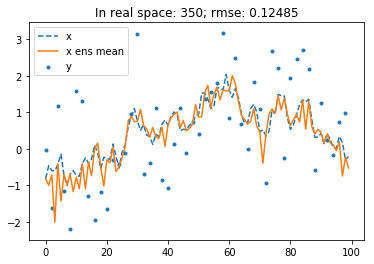

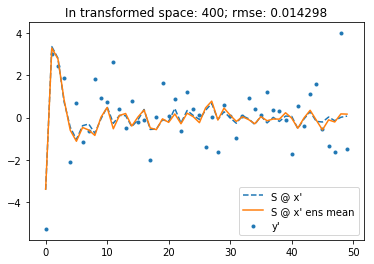

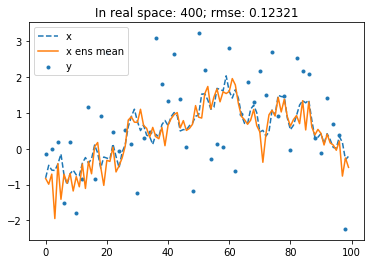

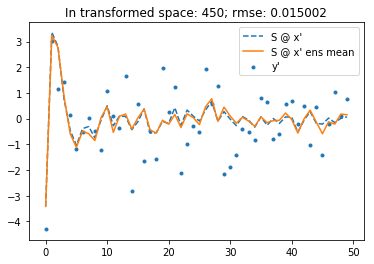

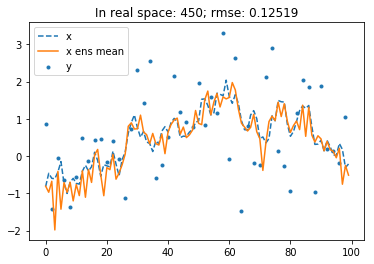

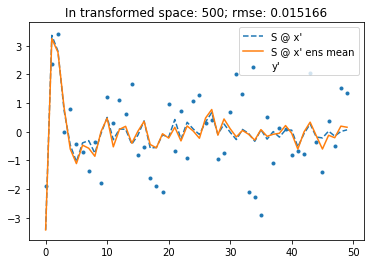

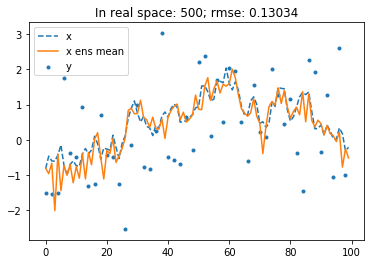

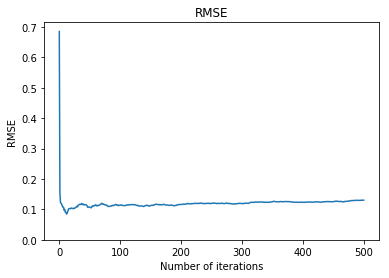

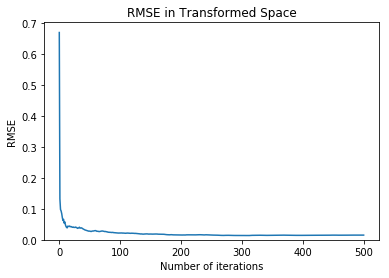

In [19]:
X_ens_kf = X_ens_p2.copy()
Y_ens_kf = Y_ens_p2.copy()
S_kf_reduced = S_ens.diagonal()[:, None]
P_kf_reduced = np.ones(y_size)[:, None]
I_reduced = np.ones(y_size)[:, None]

iterations = 500
rmse = np.ones(iterations + 1)*np.nan
rmse_t = rmse.copy()

error = (ground_truth
         - Tx_inv_ens @ X_ens_kf.mean(axis=1)[:, None])
error_t = (S_ens @ Tx_ens @ ground_truth
           - S_ens @ X_ens_kf.mean(axis=1)[:, None])
rmse[0] = (error**2).mean()
rmse_t[0] = (error_t**2).mean()

plots_t(S_ens, Tx_ens, Tx_inv_ens, Ty_inv_ens,
        ground_truth, X_ens_kf, rmse[0], rmse_t[0])

time0 = time.time()
for ii in range(iterations):
    # mu_p = X_ens_kf.mean(axis=1)[:, None]
    Y_obs = (Y_ens_kf[:, ii][:, None] 
             + U_ens.conj().T @ np.random.randn(y_size, ens_size))
    P_kf_reduced = np.var(X_ens_kf[:y_size], axis=1)[:, None]
    K = ((S_kf_reduced * P_kf_reduced)
        / (1 + S_kf_reduced**2 * P_kf_reduced))
    X_ens_kf[:y_size] = (X_ens_kf[:y_size]
                         + K * (Y_obs - S_ens @ X_ens_kf))
    error = (ground_truth
             - Tx_inv_ens @ X_ens_kf.mean(axis=1)[:, None])
    error_t = (S_ens @ Tx_ens @ ground_truth
               - S_ens @ X_ens_kf.mean(axis=1)[:, None])
    rmse[ii + 1] = (error**2).mean()
    rmse_t[ii + 1] = (error_t**2).mean()
    if (ii + 1) % round(iterations/10) == 0 or ii + 1 == 1 :
        plots_t(S_ens, Tx_ens, Tx_inv_ens, Ty_inv_ens,
                ground_truth, X_ens_kf, rmse[ii + 1],
                rmse_t[ii + 1], y=Y_ens_kf[:, ii], ii=ii)
time1 = time.time()
elapsed = (time1 - time0)/60
print('It took: ', elapsed, '\n')
print('Number of eigenvalues: ', eig_num, '\n')
print('Number of ensemble members: ', ens_size, '\n')
plt.figure()
plt.plot(rmse)
plt.ylim([0, None])
plt.title('RMSE')
plt.xlabel('Number of iterations')
plt.ylabel('RMSE')

plt.figure()
plt.plot(rmse_t)
plt.ylim([0, None])
plt.title('RMSE in Transformed Space')
plt.xlabel('Number of iterations')
plt.ylabel('RMSE')